In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import math
from tensorflow.keras.applications import InceptionResNetV2
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, MaxPooling2D, Dense, Flatten, Dropout, LeakyReLU, Conv2D, BatchNormalization

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Constants
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16
IMAGE_HEIGHT = 299
IMAGE_WIDTH = 299
EPOCHS = 30
NUM_CLASSES = 3

In [5]:
train_chicken_pox = os.path.join (r"data/training/ChickenPox")
train_measles = os.path.join (r"data/training/Measles")
train_monkey_pox = os.path.join (r"data/training/MonkeyPox")

In [6]:
val_chicken_pox = os.path.join (r"data/validation/ChickenPox")
val_measles = os.path.join (r"data/validation/Measles")
val_monkey_pox = os.path.join (r"data/validation/MonkeyPox")

## Classified Images

## ChickenPox Sample Images

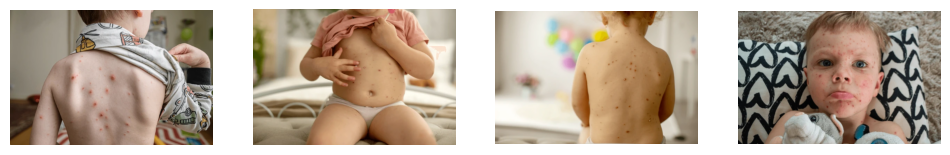

In [7]:
import matplotlib.image as mpimg
chicken_pox_img = [os.path.join(train_chicken_pox, file)
              for file in os.listdir(train_chicken_pox)[:4]]
plt.figure(figsize=(12, 4))
for i, img_path in enumerate(chicken_pox_img):
    sp = plt.subplot(1, 4, i+1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)

## Measles Sample Images

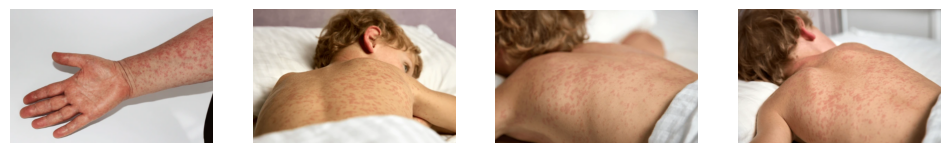

In [8]:
measles_img = [os.path.join(train_measles, file)
              for file in os.listdir(train_measles)[:4]]
plt.figure(figsize=(12, 4))
for i, img_path in enumerate(measles_img):
    sp = plt.subplot(1, 4, i+1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)

## Monkeypox Sample Images

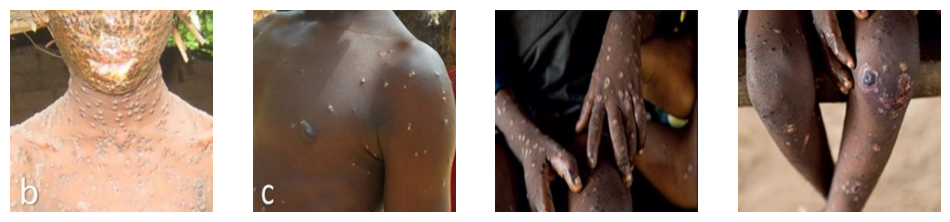

In [9]:
monkey_pox_img = [os.path.join(train_monkey_pox, file)
              for file in os.listdir(train_monkey_pox)[6:10]]
plt.figure(figsize=(12, 4))
for i, img_path in enumerate(monkey_pox_img):
    sp = plt.subplot(1, 4, i+1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)

## Custom CNN

In [10]:
datagen_c = ImageDataGenerator(         
    zoom_range=0.5, 
    rotation_range=50,          
    horizontal_flip=True,       
    fill_mode='nearest'        
)

In [50]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

In [12]:
#==================Training dataset============================
train_c = datagen_c.flow_from_directory(
    directory=r"data/training", 
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
    batch_size = BATCH_SIZE,
    class_mode='sparse',
    seed = 42
)
#==================Testing dataset============================
test_c = datagen_c.flow_from_directory(
    directory="data/test", 
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
    batch_size = BATCH_SIZE,
    class_mode='sparse',
    seed = 42
)

Found 480 images belonging to 3 classes.
Found 99 images belonging to 3 classes.


In [13]:
label_map = {'ChickenPox': 0, 'Measles': 1, 'MonkeyPox': 2}

In [14]:
def getType(id):
    return list(label_map.keys())[list(label_map.values()).index(id)]

# predict new images
def predictImagesClass(model, val_data, image_width, image_height):
    val_df = pd.DataFrame(columns=['Image No.', 'Predicted Image Class'])
    cnn_img = [os.path.join(val_data, file) 
                      for file in os.listdir(val_data)[:]]
    for i, img_path in enumerate(cnn_img):
        img = image.load_img(img_path, target_size=(image_width, image_height))
        img_array = image.img_to_array(img)
        img_batch = np.expand_dims(img_array, axis=0)
        prediction = model.predict(img_batch)
        val_df.loc[len(val_df.index)] = [(i+1), getType(np.argmax(prediction))]
    return val_df

In [15]:
model = Sequential()

In [16]:
# Adding input layer
model.add(Input(shape=(256, 256, 3)))

# Adding second convolutional layer 
model.add(Conv2D(32, (3, 3), strides=1))
model.add(LeakyReLU(negative_slope=0.01))
model.add(MaxPooling2D())
model.add(BatchNormalization())

# Adding third convolutional layer
model.add(Conv2D(64, (3, 3), strides=1))
model.add(LeakyReLU(negative_slope=0.01))
model.add(MaxPooling2D())
model.add(BatchNormalization())

# Adding forth convolutional layer 
model.add(Conv2D(128, (3, 3), strides=1, padding='same'))
model.add(LeakyReLU(negative_slope=0.01))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256))
model.add(LeakyReLU(negative_slope=0.01))

model.add(Dense(NUM_CLASSES, activation='softmax'))

In [17]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 254, 254, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 127, 127, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 125, 125, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 62, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 31, 31, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    31,490,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,585,219 (120.49 MB)

 Trainable params: 31,584,771 (120.49 MB)

 Non-trainable params: 448 (1.75 KB)

In [19]:
#=========================Checkpoint Condition=========================================
checkpoint_filepath='models/custom.keras'
model_checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [20]:
hist = model.fit(
    train_c,
    epochs = EPOCHS,
    verbose = 1, 
    validation_data = test_c,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30


I0000 00:00:1729664532.293260   35446 service.cc:146] XLA service 0x2ac06c006430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729664532.293476   35446 service.cc:154]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
E0000 00:00:1729664543.138574   35446 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729664544.249164   35446 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 2/30 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.3438 - loss: 2.4441  

I0000 00:00:1729664592.111749   35446 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.4313 - loss: 3.6847 - val_accuracy: 0.4040 - val_loss: 15.8436
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.5023 - loss: 4.4822 - val_accuracy: 0.4343 - val_loss: 6.9543
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.5325 - loss: 3.2678 - val_accuracy: 0.4747 - val_loss: 3.8128
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.6154 - loss: 2.6447 - val_accuracy: 0.4848 - val_loss: 2.2586
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5987 - loss: 2.3713 - val_accuracy: 0.3434 - val_loss: 1.8703
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6175 - loss: 1.5570 - val_accuracy: 0.4040 - val_loss: 1.8842
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6319 - loss: 1.5939 - val_accuracy: 0.4646 - val_loss: 1.9023
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6357 - loss: 1.3740 - val_accuracy: 0.3434 - val_loss: 2.5837
E

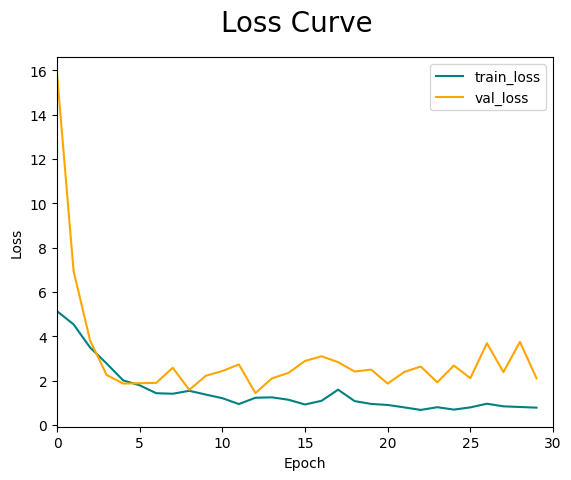

In [21]:
#==========================Loss Function===========================
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'train_loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss Curve', fontsize = 20)
plt.legend(loc = 'upper right')
plt.xlim(0,30)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

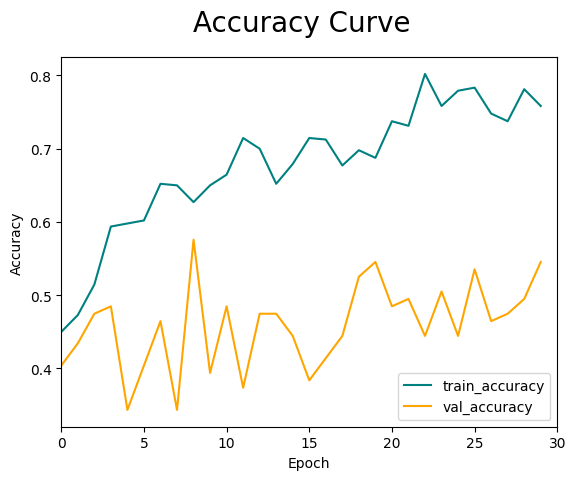

In [22]:
#==========================Accuracy===========================
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'train_accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy Curve', fontsize = 20)
plt.legend(loc = 'lower right')
plt.xlim(0,30)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [48]:
model = tf.keras.models.load_model('models/custom.keras')

In [51]:
chickenpox_val_df_cnn = predictImagesClass(model, val_chicken_pox, IMAGE_WIDTH, IMAGE_HEIGHT)
chickenpox_val_df_cnn["True Image Labels"] = "ChickenPox"
display(chickenpox_val_df_cnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


,Image No.,Predicted Image Class,True Image Labels
0,1,Measles,ChickenPox
1,2,ChickenPox,ChickenPox
2,3,Measles,ChickenPox
3,4,Measles,ChickenPox
4,5,ChickenPox,ChickenPox
5,6,ChickenPox,ChickenPox
6,7,Measles,ChickenPox
7,8,ChickenPox,ChickenPox


In [52]:
measles_val_df_cnn = predictImagesClass(model, val_measles, IMAGE_WIDTH, IMAGE_HEIGHT)
measles_val_df_cnn["True Image Labels"] = "Measles"
display(measles_val_df_cnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


,Image No.,Predicted Image Class,True Image Labels
0,1,Measles,Measles
1,2,ChickenPox,Measles
2,3,ChickenPox,Measles
3,4,Measles,Measles
4,5,Measles,Measles
5,6,Measles,Measles
6,7,ChickenPox,Measles
7,8,MonkeyPox,Measles


In [53]:
monkey_pox_df_cnn = predictImagesClass(model, val_monkey_pox, IMAGE_WIDTH, IMAGE_HEIGHT) 
monkey_pox_df_cnn["True Image Labels"] = "MonkeyPox"
display(monkey_pox_df_cnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


,Image No.,Predicted Image Class,True Image Labels
0,1,Measles,MonkeyPox
1,2,MonkeyPox,MonkeyPox
2,3,MonkeyPox,MonkeyPox
3,4,MonkeyPox,MonkeyPox
4,5,MonkeyPox,MonkeyPox
5,6,Measles,MonkeyPox
6,7,ChickenPox,MonkeyPox
7,8,ChickenPox,MonkeyPox


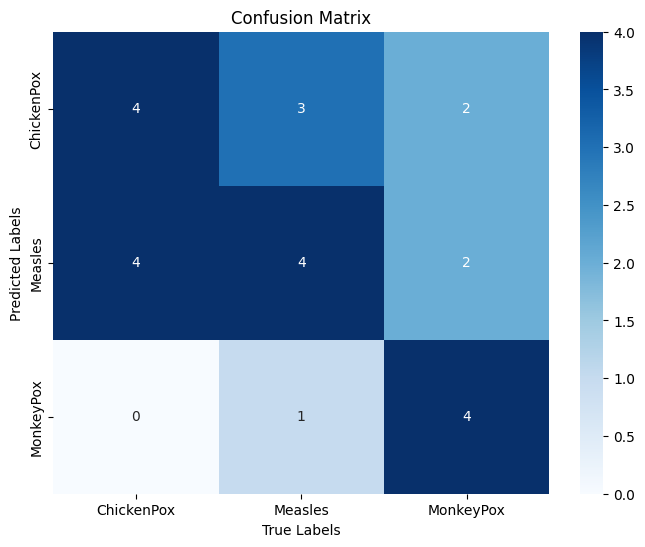

In [54]:
combined_df = pd.concat([chickenpox_val_df_cnn, measles_val_df_cnn, monkey_pox_df_cnn])

y_pred = combined_df['Predicted Image Class']
y_true = combined_df['True Image Labels']

cm = confusion_matrix(y_pred, y_true, labels=['ChickenPox', 'Measles', 'MonkeyPox'])

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ChickenPox', 'Measles', 'MonkeyPox'], yticklabels=['ChickenPox', 'Measles', 'MonkeyPox'])
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

# Inception-ResNet V2

In [29]:
IMAGE_HEIGHT = 299
IMAGE_WIDTH = 299

In [30]:
#================================Augmentation of the image=============================
datagen = ImageDataGenerator(horizontal_flip=True,zoom_range=0.5,
                            fill_mode='nearest')

In [31]:
#==================Training dataset============================
train = datagen.flow_from_directory(
    directory=r"data/training", 
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
    batch_size = BATCH_SIZE,
    class_mode='sparse',
    seed = 42
)
#==================Testing dataset============================
test = datagen.flow_from_directory(
    directory="data/test", 
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
    batch_size = BATCH_SIZE,
    class_mode='sparse',
    seed = 42
)

Found 480 images belonging to 3 classes.
Found 99 images belonging to 3 classes.


In [32]:
model1 = InceptionResNetV2(weights='imagenet')

In [33]:
optimizer = Adam(learning_rate=0.0001)
model1.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
checkpoint_filepath='models/inception_resnetv2.keras'
model_checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [35]:
hist2 = model1.fit(
    train,
    epochs = EPOCHS,
    verbose = 1,
    validation_data = test,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30


E0000 00:00:1729668103.476256   35446 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729668104.602305   35446 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1299s 7s/step - accuracy: 0.1943 - loss: 5.3665 - val_accuracy: 0.6869 - val_loss: 1.6929
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.8714 - loss: 0.6687 - val_accuracy: 0.6869 - val_loss: 1.4665
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.9397 - loss: 0.2789 - val_accuracy: 0.8586 - val_loss: 0.8267
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9372 - loss: 0.2853 - val_accuracy: 0.8485 - val_loss: 0.6361
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9490 - loss: 0.1574 - val_accuracy: 0.8485 - val_loss: 0.7790
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.9676 - loss: 0.1130 - val_accuracy: 0.8687 - val_loss: 0.5477
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.9870 - loss: 0.0589 - val_accuracy: 0.8788 - val_loss: 0.5008
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.9848 - loss: 0.0445 - val_accuracy: 0.9293 - val_loss: 0.2921
E

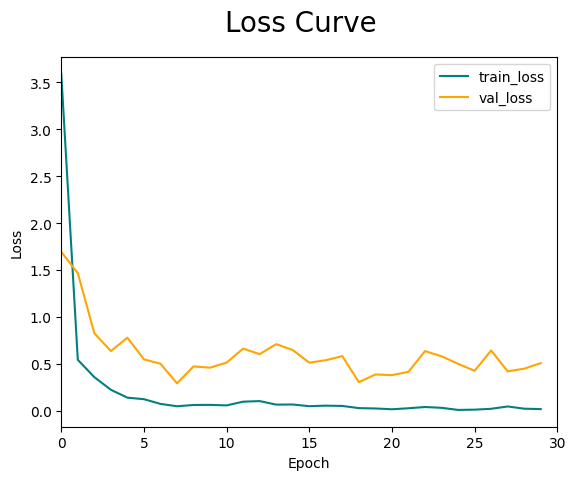

In [39]:
### ==========================Loss Function===========================
fig = plt.figure()
plt.plot(hist2.history['loss'], color = 'teal', label = 'train_loss')
plt.plot(hist2.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss Curve', fontsize = 20)
plt.legend(loc = 'upper right')
plt.xlim(0,30)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

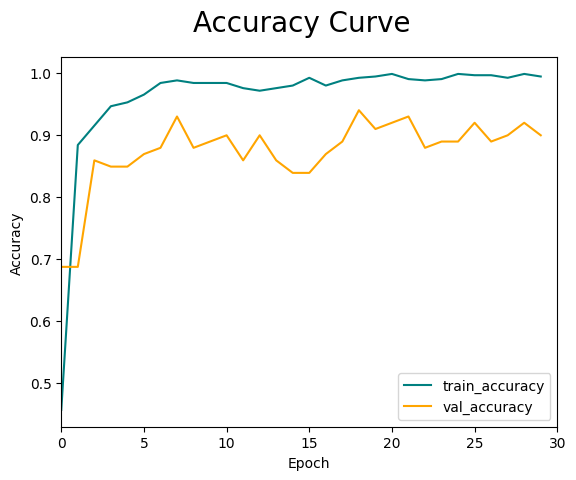

In [40]:
#==========================Accuracy===========================
fig = plt.figure()
plt.plot(hist2.history['accuracy'], color = 'teal', label = 'train_accuracy')
plt.plot(hist2.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy Curve', fontsize = 20)
plt.legend(loc = 'lower right')
plt.xlim(0,30)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [41]:
model = tf.keras.models.load_model('models/inception_resnetv2.keras')

In [42]:
chickenpox_val_df_cnn = predictImagesClass(model, val_chicken_pox, IMAGE_WIDTH, IMAGE_HEIGHT)
chickenpox_val_df_cnn["True Image Labels"] = "ChickenPox"
display(chickenpox_val_df_cnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 80s 80s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


,Image No.,Predicted Image Class,True Image Labels
0,1,ChickenPox,ChickenPox
1,2,ChickenPox,ChickenPox
2,3,ChickenPox,ChickenPox
3,4,ChickenPox,ChickenPox
4,5,ChickenPox,ChickenPox
5,6,ChickenPox,ChickenPox
6,7,ChickenPox,ChickenPox
7,8,Measles,ChickenPox


In [43]:
measles_val_df_cnn = predictImagesClass(model, val_measles, IMAGE_WIDTH, IMAGE_HEIGHT)
measles_val_df_cnn["True Image Labels"] = "Measles"
display(measles_val_df_cnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


,Image No.,Predicted Image Class,True Image Labels
0,1,Measles,Measles
1,2,Measles,Measles
2,3,Measles,Measles
3,4,ChickenPox,Measles
4,5,ChickenPox,Measles
5,6,Measles,Measles
6,7,Measles,Measles
7,8,Measles,Measles


In [44]:
monkey_pox_df_cnn = predictImagesClass(model, val_monkey_pox, IMAGE_WIDTH, IMAGE_HEIGHT) 
monkey_pox_df_cnn["True Image Labels"] = "MonkeyPox"
display(monkey_pox_df_cnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


,Image No.,Predicted Image Class,True Image Labels
0,1,MonkeyPox,MonkeyPox
1,2,MonkeyPox,MonkeyPox
2,3,MonkeyPox,MonkeyPox
3,4,ChickenPox,MonkeyPox
4,5,ChickenPox,MonkeyPox
5,6,Measles,MonkeyPox
6,7,ChickenPox,MonkeyPox
7,8,MonkeyPox,MonkeyPox


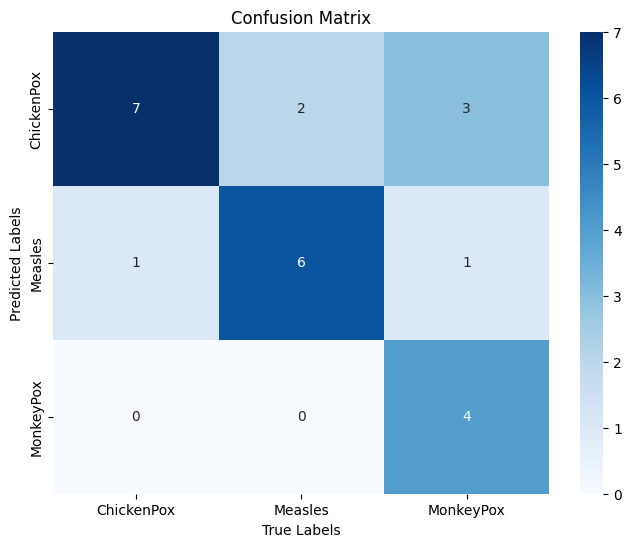

In [47]:
combined_df = pd.concat([chickenpox_val_df_cnn, measles_val_df_cnn, monkey_pox_df_cnn])

y_pred = combined_df['Predicted Image Class']
y_true = combined_df['True Image Labels']

cm = confusion_matrix(y_pred, y_true, labels=['ChickenPox', 'Measles', 'MonkeyPox'])

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ChickenPox', 'Measles', 'MonkeyPox'], yticklabels=['ChickenPox', 'Measles', 'MonkeyPox'])
plt.ylabel('Predicted Labels')
plt.xlabel('True Labels')
plt.title('Confusion Matrix')
plt.show()